### Code Hist.

 - CODE  
    &ensp; : Crawling - 특일 정보 조회 (KASI)

  - DATE  
    &ensp; 2023-11-29 Created  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1)   
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2)    
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 3)   
    
 - DESC  
    &ensp; : 전처리 - 한국지역난방공사 열판매량/열공급량   
    &emsp; 1) 결측치가 없어서, 그대로 사용  
    &emsp;&ensp;&ensp; 
    &emsp;&ensp;&ensp; (Crawl Code 없음)   
    &emsp; 2) 

 - DATA  
    &emsp; <"Input">  
    1) None (Input Dataset)  
    &emsp;- Period :   
    &emsp;- Interval : 

    &emsp; <"Output">  
    1) Hourly (관측소/년도별 출력)  
    &nbsp;df_data_cal.to_csv(data_dir + 'KASI_DATE_D_Final.csv', index = False, encoding='utf-8-sig')  
    &emsp;- Columns : ['YEAR', 'MONTH', 'DAY'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'dateKind', 'code_day_of_the_week', 'day_of_the_week'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'rest_YN', 'name_of_holiday', 'dist_from_holiday']
    &emsp;- Period :   
    &emsp;- Interval :  
    
    2) Daily (관측소/년도별 출력)  
    &nbsp;df_data_cal_24.to_csv(data_dir + 'KASI_DATE_H_Final.csv', index = False, encoding='utf-8-sig')  
    &emsp;- Columns : ['locdate', 'YEAR', 'MONTH', 'DAY'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'dateKind', 'code_day_of_the_week', 'day_of_the_week'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'rest_YN', 'name_of_holiday', 'dist_from_holiday'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'HOUR', 'MINUTE']
    &emsp;- Period :   
    &emsp;- Interval :  
    
    

 - Related Link  
    &ensp; : 

# 01. Code

## 01-01. Init

### 01-01-01. Init_Module Import

In [30]:
#region Basic_Import
## Basic
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import random
from pandas import DataFrame, Series

## Datetime
import time
import datetime as dt
from datetime import datetime, date, timedelta

import glob
from glob import glob
import requests
import json

## 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

from scipy import stats

## TSNE
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE

## 정규화
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
## Modeling, Model Training
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
## Model 평가
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score   # model.score   

## Excel/CSV
import openpyxl, xlrd

import urllib
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus

from selenium import webdriver
from selenium.webdriver.chrome.service import Service

from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

## Init.
pd.options.display.float_format = '{:.10f}'.format
#endregion Basic_Import

In [31]:
## Import_DL
str_tar = "tf"
## For Torch
if str_tar == "torch":
    import torch
    import torch.nn as nn
    from torch.nn.utils import weight_norm
    print("Torch Imported")
## For TF
elif str_tar == "tf":
    import tensorflow as tf
    import tensorflow_addons as tfa
    print("Tensorflow Imported")
else:
    print("Error : Cannot be used except for Keywords")
    print(" : torch / tf")

Tensorflow Imported


In [32]:
# !pip install lightgbm

## LGBM
import lightgbm as lgbm
from lightgbm import LGBMRegressor

## XGB
## https://magoker.tistory.com/106
import xgboost as xgb
from xgboost import plot_importance, plot_tree, XGBClassifier

In [33]:
## Import_Local (현재 프로그램에서 미사용)
from DEV_Common_Data_Visualization import visualization_df

### 01-01-02. Config (Directory, Params)

In [34]:
## Init_config
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = "1"
random.seed(SEED)

In [35]:
## Define Todate str
str_now_ymd = pd.datetime.now().date()
str_now_y = pd.datetime.now().year
str_now_m = pd.datetime.now().month
str_now_d = pd.datetime.now().day
str_now_hr = pd.datetime.now().hour
str_now_min = pd.datetime.now().minute

print(pd.datetime.now())
print(str(str_now_y) + " / " + str(str_now_m)  + " / " + str(str_now_d))
print(str(str_now_hr) + " : " + str(str_now_min))

2023-12-29 11:48:37.486392
2023 / 12 / 29
11 : 48


## 01-02. Data Load (df_raw)

### 01-02-01. KDHC Heat Usage (PCA Added)

In [36]:
# Define data root directory
str_dir_kdhcHeat = "./data_Energy_KDHC_National_Heat/"
print(os.listdir(str_dir_kdhcHeat))

df_kdhc_heat = pd.read_csv(str_dir_kdhcHeat + 'KDHC_COMB_HEATxWEATHER_2019-2022.csv', index_col = 0)
print(df_kdhc_heat.columns)
df_kdhc_heat

['KDHC_COMB_HEAT-CJ_ASOS_KASI_2010-2023.csv', 'KDHC_COMB_HEATSxPCA01_2019-2022_Scaled.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_complete_analysis.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_linearReg.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_mean_imp.csv', 'KDHC_COMB_HEAT_2019-2022.csv', 'KDHC_COMB_KANGNAMHEATxWEATHER_2019-2022.csv', 'KDHC_HEAT', 'KDHC_HEAT.zip', 'KDHC_HEAT_19Region_hr.csv', 'KDHC_HEAT_CHEONGJU_2010_2021.csv', 'KDHC_HEAT_CHEONGJU_2010_2021_1st_Check.csv', 'KDHC_HEAT_SEJONG_2014_2018.csv', 'KDHC_HEAT_SEJONG_2014_2018_1st_Check.csv', 'KDHC_NATIONAL_HEAT_hr.csv', 'KDHC_NATIONAL_HEAT_RAW_hr.csv']
Index(['METER_DATE', 'day_of_the_week', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'MINUTE', 'code_day_of_the_week', 'rest_YN', 'dist_from_holiday',
       'temp_outdoor', 'temp_dew_point', 'temp_ground', 'humidity', 'rainfall',
       'snowfall', 'snowfall_3hr', 'wind_speed', 'wind_direction',
       'pressure_vapor', 'pressure_area', 'pressure_sea', '

,METER_DATE,day_of_the_week,YEAR,MONTH,DAY,HOUR,MINUTE,code_day_of_the_week,rest_YN,dist_from_holiday,...,SUWON,HWASUNG,DONGTAN,PYONGTAEK,CHEONGJU,SEJONG,KIMHAE,DAEGU,YANGSAN,GWANGJU_JEONNAM
0,2019-10-01 01:00:00,Tuesday,2019,10,1,1,0,1,0,2,...,26.0000000000,11.0000000000,21,0.5000000000,16,18.0000000000,8,19.0000000000,10,3
1,2019-10-01 01:00:00,Tuesday,2019,10,1,1,0,1,0,2,...,26.0000000000,11.0000000000,21,0.5000000000,16,18.0000000000,8,19.0000000000,10,3
2,2019-10-01 02:00:00,Tuesday,2019,10,1,2,0,1,0,2,...,29.0000000000,12.0000000000,16,0.5000000000,13,15.0000000000,7,16.0000000000,9,2
3,2019-10-01 02:00:00,Tuesday,2019,10,1,2,0,1,0,2,...,29.0000000000,12.0000000000,16,0.5000000000,13,15.0000000000,7,16.0000000000,9,2
4,2019-10-01 03:00:00,Tuesday,2019,10,1,3,0,1,0,2,...,33.0000000000,12.0000000000,14,0.5000000000,10,15.0000000000,7,15.0000000000,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27298,2022-09-30 20:00:00,Friday,2022,9,30,20,0,4,0,1,...,73.0000000000,39.0000000000,61,12.0000000000,36,44.0000000000,12,30.0000000000,18,6
27299,2022-09-30 21:00:00,Friday,2022,9,30,21,0,4,0,1,...,71.0000000000,36.0000000000,55,4.0000000000,30,44.0000000000,11,35.0000000000,22,5
27300,2022-09-30 22:00:00,Friday,2022,9,30,22,0,4,0,1,...,65.0000000000,29.0000000000,45,2.0000000000,27,43.0000000000,12,32.0000000000,22,6
27301,2022-09-30 23:00:00,Friday,2022,9,30,23,0,4,0,1,...,64.0000000000,25.0000000000,32,3.0000000000,25,40.0000000000,11,34.0000000000,22,6


In [37]:
for i in range(0, len(df_kdhc_heat)):
    if df_kdhc_heat['rest_YN'].iloc[i] == 'N':
        df_kdhc_heat['rest_YN'].iloc[i] = 0
    elif df_kdhc_heat['rest_YN'].iloc[i] == 'Y':
        df_kdhc_heat['rest_YN'].iloc[i] = 1
df_kdhc_heat['rest_YN'] = df_kdhc_heat['rest_YN'].astype(int)

In [38]:
for i in range(0, len(df_kdhc_heat)):
    if df_kdhc_heat['dist_from_holiday'].iloc[i] == '제헌절':
        df_kdhc_heat['dist_from_holiday'].iloc[i] = 0
    # elif df_kdhc_heat['rest_YN'].iloc[i] == 'Y':
        # df_kdhc_heat['rest_YN'].iloc[i] = 1

df_kdhc_heat['dist_from_holiday'] = df_kdhc_heat['dist_from_holiday'].astype(int)

In [39]:
# Define data root directory
str_dir_kdhcHeat = "./data_Energy_KDHC_National_Heat/"
str_file = "KDHC_COMB_HEATSxPCA01_2019-2022_Scaled.csv"
print(os.listdir(str_dir_kdhcHeat))

df_kdhc_heat_scaled = pd.read_csv(str_dir_kdhcHeat + str_file, index_col = 0)
print(df_kdhc_heat_scaled .columns)
df_kdhc_heat_scaled

['KDHC_COMB_HEAT-CJ_ASOS_KASI_2010-2023.csv', 'KDHC_COMB_HEATSxPCA01_2019-2022_Scaled.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_complete_analysis.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_linearReg.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_mean_imp.csv', 'KDHC_COMB_HEAT_2019-2022.csv', 'KDHC_COMB_KANGNAMHEATxWEATHER_2019-2022.csv', 'KDHC_HEAT', 'KDHC_HEAT.zip', 'KDHC_HEAT_19Region_hr.csv', 'KDHC_HEAT_CHEONGJU_2010_2021.csv', 'KDHC_HEAT_CHEONGJU_2010_2021_1st_Check.csv', 'KDHC_HEAT_SEJONG_2014_2018.csv', 'KDHC_HEAT_SEJONG_2014_2018_1st_Check.csv', 'KDHC_NATIONAL_HEAT_hr.csv', 'KDHC_NATIONAL_HEAT_RAW_hr.csv']
Index(['METER_DATE', 'PAJU_s', 'GOYANG_s', 'SAMSONG_s', 'JOONGANG_s',
       'KANGNAM_s', 'PANGYO_s', 'BUNDANG_s', 'YONGIN_s', 'GWANGGYO_s',
       'SUWON_s', 'HWASUNG_s', 'DONGTAN_s', 'PYONGTAEK_s', 'CHEONGJU_s',
       'SEJONG_s', 'KIMHAE_s', 'DAEGU_s', 'YANGSAN_s', 'GWANGJU_JEONNAM_s',
       'pca_component_1', 'pca_component_2', 'pca_component_3

,METER_DATE,PAJU_s,GOYANG_s,SAMSONG_s,JOONGANG_s,KANGNAM_s,PANGYO_s,BUNDANG_s,YONGIN_s,GWANGGYO_s,...,PYONGTAEK_s,CHEONGJU_s,SEJONG_s,KIMHAE_s,DAEGU_s,YANGSAN_s,GWANGJU_JEONNAM_s,pca_component_1,pca_component_2,pca_component_3
0,2019-10-01 01:00:00,-0.7147964754,-0.8308263752,-1.4089350360,-0.9755030854,-0.9855209275,-1.2245448656,-0.8414230972,-1.1323359032,-1.2597788828,...,-1.0874523922,-0.9962839850,-1.2209819272,-0.8828028457,-0.9449895775,-0.9606640730,-1.2406363915,-4.5486431464,-0.8102644725,0.0480436434
1,2019-10-01 01:00:00,-0.7147964754,-0.8308263752,-1.4089350360,-0.9755030854,-0.9855209275,-1.2245448656,-0.8414230972,-1.1323359032,-1.2597788828,...,-1.0874523922,-0.9962839850,-1.2209819272,-0.8828028457,-0.9449895775,-0.9606640730,-1.2406363915,-4.5486431464,-0.8102644725,0.0480436434
2,2019-10-01 02:00:00,-0.8390127324,-0.8746698773,-1.3055171256,-0.9975373727,-0.9855209275,-1.3313932739,-0.8337886340,-1.1647685666,-1.5090492005,...,-1.0874523922,-1.0517008270,-1.2707243720,-0.9347358934,-0.9879187421,-0.9988638688,-1.3494879960,-4.7385097055,-0.9486422792,0.1341413624
3,2019-10-01 02:00:00,-0.8390127324,-0.8746698773,-1.3055171256,-0.9975373727,-0.9855209275,-1.3313932739,-0.8337886340,-1.1647685666,-1.5090492005,...,-1.0874523922,-1.0517008270,-1.2707243720,-0.9347358934,-0.9879187421,-0.9988638688,-1.3494879960,-4.7385097055,-0.9486422792,0.1341413624
4,2019-10-01 03:00:00,-0.8638559838,-0.9130329416,-1.3055171256,-1.0085545164,-1.0124515233,-1.3046811719,-0.8762023186,-1.2101742953,-1.3666090189,...,-1.0874523922,-1.1071176691,-1.2707243720,-0.9347358934,-1.0022284637,-1.0370636646,-1.2406363915,-4.7505418230,-0.8333600392,0.0807661015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27298,2022-09-30 20:00:00,-0.1930881958,-0.7869828732,-0.4781738426,-0.7000744938,-0.6693557326,-0.4498939052,-0.6777062746,-0.7626035408,-0.3339177028,...,1.0798808470,-0.6268383713,-0.7898807393,-0.6750706549,-0.7875826404,-0.6550657067,-0.9140815780,-2.3798343863,0.7682451798,1.3599420785
27299,2022-09-30 21:00:00,-0.2179314472,-0.7376589333,-0.4264648874,-0.6890573502,-0.7124446859,-0.4766060073,-0.6437753269,-0.7366574101,-0.8680683836,...,-0.4278292324,-0.7376720554,-0.7898807393,-0.7270037026,-0.7160340326,-0.5022665235,-1.0229331825,-2.7885250626,-0.1286691027,0.2426072679
27300,2022-09-30 22:00:00,-0.2924612014,-0.7102567445,-0.6074462305,-0.7110916375,-0.8040087117,-0.7971512323,-0.7540509069,-0.8015227369,-1.1885587920,...,-0.8047567523,-0.7930888975,-0.8064615542,-0.6750706549,-0.7589631973,-0.5022665235,-0.9140815780,-3.1819057640,-0.5824119183,0.1296520362
27301,2022-09-30 23:00:00,-0.4166774585,-0.6938154313,-0.7108641409,-0.7441430685,-0.8363254267,-0.9307117427,-0.8728092239,-0.8080092695,-1.1885587920,...,-0.6162929924,-0.8300334588,-0.8562039990,-0.7270037026,-0.7303437542,-0.5022665235,-0.9140815780,-3.3753256983,-0.6003969781,0.3196417328


In [40]:
df_kdhc_heat_comb = pd.merge(df_kdhc_heat, df_kdhc_heat_scaled
                             , how = 'left', on = ['METER_DATE'])
print(df_kdhc_heat_comb.columns)
df_kdhc_heat_comb

Index(['METER_DATE', 'day_of_the_week', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'MINUTE', 'code_day_of_the_week', 'rest_YN', 'dist_from_holiday',
       'temp_outdoor', 'temp_dew_point', 'temp_ground', 'humidity', 'rainfall',
       'snowfall', 'snowfall_3hr', 'wind_speed', 'wind_direction',
       'pressure_vapor', 'pressure_area', 'pressure_sea', 'sunshine',
       'solar_radiation', 'cloud_total', 'cloud_midlow', 'visual_range',
       'PAJU', 'GOYANG', 'SAMSONG', 'JOONGANG', 'KANGNAM', 'PANGYO', 'BUNDANG',
       'YONGIN', 'GWANGGYO', 'SUWON', 'HWASUNG', 'DONGTAN', 'PYONGTAEK',
       'CHEONGJU', 'SEJONG', 'KIMHAE', 'DAEGU', 'YANGSAN', 'GWANGJU_JEONNAM',
       'PAJU_s', 'GOYANG_s', 'SAMSONG_s', 'JOONGANG_s', 'KANGNAM_s',
       'PANGYO_s', 'BUNDANG_s', 'YONGIN_s', 'GWANGGYO_s', 'SUWON_s',
       'HWASUNG_s', 'DONGTAN_s', 'PYONGTAEK_s', 'CHEONGJU_s', 'SEJONG_s',
       'KIMHAE_s', 'DAEGU_s', 'YANGSAN_s', 'GWANGJU_JEONNAM_s',
       'pca_component_1', 'pca_component_2', 'pca_componen

,METER_DATE,day_of_the_week,YEAR,MONTH,DAY,HOUR,MINUTE,code_day_of_the_week,rest_YN,dist_from_holiday,...,PYONGTAEK_s,CHEONGJU_s,SEJONG_s,KIMHAE_s,DAEGU_s,YANGSAN_s,GWANGJU_JEONNAM_s,pca_component_1,pca_component_2,pca_component_3
0,2019-10-01 01:00:00,Tuesday,2019,10,1,1,0,1,0,2,...,-1.0874523922,-0.9962839850,-1.2209819272,-0.8828028457,-0.9449895775,-0.9606640730,-1.2406363915,-4.5486431464,-0.8102644725,0.0480436434
1,2019-10-01 01:00:00,Tuesday,2019,10,1,1,0,1,0,2,...,-1.0874523922,-0.9962839850,-1.2209819272,-0.8828028457,-0.9449895775,-0.9606640730,-1.2406363915,-4.5486431464,-0.8102644725,0.0480436434
2,2019-10-01 01:00:00,Tuesday,2019,10,1,1,0,1,0,2,...,-1.0874523922,-0.9962839850,-1.2209819272,-0.8828028457,-0.9449895775,-0.9606640730,-1.2406363915,-4.5486431464,-0.8102644725,0.0480436434
3,2019-10-01 01:00:00,Tuesday,2019,10,1,1,0,1,0,2,...,-1.0874523922,-0.9962839850,-1.2209819272,-0.8828028457,-0.9449895775,-0.9606640730,-1.2406363915,-4.5486431464,-0.8102644725,0.0480436434
4,2019-10-01 02:00:00,Tuesday,2019,10,1,2,0,1,0,2,...,-1.0874523922,-1.0517008270,-1.2707243720,-0.9347358934,-0.9879187421,-0.9988638688,-1.3494879960,-4.7385097055,-0.9486422792,0.1341413624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29296,2022-09-30 20:00:00,Friday,2022,9,30,20,0,4,0,1,...,1.0798808470,-0.6268383713,-0.7898807393,-0.6750706549,-0.7875826404,-0.6550657067,-0.9140815780,-2.3798343863,0.7682451798,1.3599420785
29297,2022-09-30 21:00:00,Friday,2022,9,30,21,0,4,0,1,...,-0.4278292324,-0.7376720554,-0.7898807393,-0.7270037026,-0.7160340326,-0.5022665235,-1.0229331825,-2.7885250626,-0.1286691027,0.2426072679
29298,2022-09-30 22:00:00,Friday,2022,9,30,22,0,4,0,1,...,-0.8047567523,-0.7930888975,-0.8064615542,-0.6750706549,-0.7589631973,-0.5022665235,-0.9140815780,-3.1819057640,-0.5824119183,0.1296520362
29299,2022-09-30 23:00:00,Friday,2022,9,30,23,0,4,0,1,...,-0.6162929924,-0.8300334588,-0.8562039990,-0.7270037026,-0.7303437542,-0.5022665235,-0.9140815780,-3.3753256983,-0.6003969781,0.3196417328


In [41]:
col_tar = 'CHEONGJU_s'
df_kdhc_heat_comb = df_kdhc_heat_comb[['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week', 'day_of_the_week', 'rest_YN', 'dist_from_holiday'
                                       , 'HOUR', 'MINUTE'
                                       , 'temp_outdoor', 'temp_dew_point', 'temp_ground'
                                       , 'humidity'
                                       , 'rainfall', 'snowfall', 'snowfall_3hr'
                                       , 'wind_speed', 'wind_direction'
                                       , 'pressure_vapor', 'pressure_area', 'pressure_sea'
                                       , 'sunshine', 'solar_radiation'
                                       , 'cloud_total', 'cloud_midlow'
                                       , 'visual_range'
                                       , 'pca_component_1', 'pca_component_2', 'pca_component_3'
                                       , col_tar]]
print(df_kdhc_heat_comb.shape)
df_kdhc_heat_comb

(29301, 31)


,METER_DATE,YEAR,MONTH,DAY,code_day_of_the_week,day_of_the_week,rest_YN,dist_from_holiday,HOUR,MINUTE,...,pressure_sea,sunshine,solar_radiation,cloud_total,cloud_midlow,visual_range,pca_component_1,pca_component_2,pca_component_3,CHEONGJU_s
0,2019-10-01 01:00:00,2019,10,1,1,Tuesday,0,2,1,0,...,1017.9000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,455.0000000000,-4.5486431464,-0.8102644725,0.0480436434,-0.9962839850
1,2019-10-01 01:00:00,2019,10,1,1,Tuesday,0,2,1,0,...,1017.9000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,455.0000000000,-4.5486431464,-0.8102644725,0.0480436434,-0.9962839850
2,2019-10-01 01:00:00,2019,10,1,1,Tuesday,0,2,1,0,...,1017.9000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,455.0000000000,-4.5486431464,-0.8102644725,0.0480436434,-0.9962839850
3,2019-10-01 01:00:00,2019,10,1,1,Tuesday,0,2,1,0,...,1017.9000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,455.0000000000,-4.5486431464,-0.8102644725,0.0480436434,-0.9962839850
4,2019-10-01 02:00:00,2019,10,1,1,Tuesday,0,2,2,0,...,1017.8000000000,0.0000000000,0.0000000000,2.0000000000,0.0000000000,336.0000000000,-4.7385097055,-0.9486422792,0.1341413624,-1.0517008270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29296,2022-09-30 20:00:00,2022,9,30,4,Friday,0,1,20,0,...,1016.5000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,320.0000000000,-2.3798343863,0.7682451798,1.3599420785,-0.6268383713
29297,2022-09-30 21:00:00,2022,9,30,4,Friday,0,1,21,0,...,1016.9000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,257.0000000000,-2.7885250626,-0.1286691027,0.2426072679,-0.7376720554
29298,2022-09-30 22:00:00,2022,9,30,4,Friday,0,1,22,0,...,1017.1000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,277.0000000000,-3.1819057640,-0.5824119183,0.1296520362,-0.7930888975
29299,2022-09-30 23:00:00,2022,9,30,4,Friday,0,1,23,0,...,1017.1000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,237.0000000000,-3.3753256983,-0.6003969781,0.3196417328,-0.8300334588


In [42]:
df_kdhc_heat_WD = df_kdhc_heat_comb[df_kdhc_heat_comb['rest_YN'] == 0]
## 변수 제외
## REST_YN : 모든 값이 0이므로
## MINUTE : 무의미한 변수
df_kdhc_heat_WD = df_kdhc_heat_WD[['YEAR', 'MONTH', 'DAY', 'code_day_of_the_week', 'dist_from_holiday'
                                   , 'HOUR'
                                   , 'temp_outdoor', 'temp_dew_point', 'temp_ground'
                                   , 'humidity'
                                   , 'rainfall', 'snowfall', 'snowfall_3hr'
                                   , 'wind_speed', 'wind_direction'
                                   , 'pressure_vapor', 'pressure_area', 'pressure_sea'
                                   , 'sunshine', 'solar_radiation'
                                   , 'cloud_total', 'cloud_midlow'
                                   , 'visual_range'
                                   , 'pca_component_1'#, 'pca_component_2', 'pca_component_3'
                                   , col_tar]]
print(df_kdhc_heat_WD.shape)

df_kdhc_heat_WE = df_kdhc_heat_comb[df_kdhc_heat_comb['rest_YN'] == 1]
## 변수 제외
## REST_YN : 모든 값이 1이므로
## MINUTE : 무의미한 변수
## DIST_FROM_HOLIDAY : 모든 값이 0이므로
df_kdhc_heat_WE = df_kdhc_heat_WE[['YEAR', 'MONTH', 'DAY', 'code_day_of_the_week'
                                   , 'HOUR'
                                   , 'temp_outdoor', 'temp_dew_point', 'temp_ground'
                                   , 'humidity'
                                   , 'rainfall', 'snowfall', 'snowfall_3hr'
                                   , 'wind_speed', 'wind_direction'
                                   , 'pressure_vapor', 'pressure_area', 'pressure_sea'
                                   , 'sunshine', 'solar_radiation'
                                   , 'cloud_total', 'cloud_midlow'
                                   , 'visual_range'
                                   , 'pca_component_1'#, 'pca_component_2', 'pca_component_3'
                                   , col_tar]]
print(df_kdhc_heat_WE.shape)

(19892, 25)
(9409, 24)


In [43]:
# visualization_df(df_kdhc_heat_WD, col_tar, 'blue')
# visualization_df(df_kdhc_heat_WE, col_tar, 'blue')

In [44]:
## 상관관계 분석
## 상관관계 변수 생성
df_corr = df_kdhc_heat_WD.corr()
df_corr.corr()

,YEAR,MONTH,DAY,code_day_of_the_week,dist_from_holiday,HOUR,temp_outdoor,temp_dew_point,temp_ground,humidity,...,pressure_vapor,pressure_area,pressure_sea,sunshine,solar_radiation,cloud_total,cloud_midlow,visual_range,pca_component_1,CHEONGJU_s
YEAR,1.0000000000,-0.6445553143,0.0519193912,0.0078134202,0.0343500160,0.0562127441,0.1470118251,0.0924977662,0.1685139309,-0.1282812241,...,0.1350278921,-0.2640644019,-0.2613534298,0.0492975637,0.1452333523,0.1148762498,0.0866263252,0.0894977715,-0.0131720496,-0.0412240850
MONTH,-0.6445553143,1.0000000000,-0.0466290617,0.0073524457,-0.0388607318,-0.0810693307,0.4421279390,0.4833875430,0.3979745423,0.3401552311,...,0.4496885177,-0.3033953269,-0.3073781128,-0.0956175028,-0.0422996523,0.2372632774,0.1902575394,-0.1498868583,-0.5534888969,-0.5313375614
DAY,0.0519193912,-0.0466290617,1.0000000000,-0.0336752457,0.0480539721,-0.0624766792,0.0094510411,0.0196538402,-0.0041380057,0.0404603766,...,0.0038608943,-0.0502930972,-0.0493500028,-0.0798759109,-0.0653156558,0.0363866086,0.0305254128,-0.0454633505,-0.0287582110,-0.0258365650
code_day_of_the_week,0.0078134202,0.0073524457,-0.0336752457,1.0000000000,-0.9946499389,0.0152731328,0.0332377990,0.0134358014,0.0317525710,-0.0579016623,...,0.0186123674,-0.0091719631,-0.0097565818,0.0284915862,0.0345775163,-0.0082499333,-0.0111833834,0.0484286525,-0.0286617006,-0.0253790375
dist_from_holiday,0.0343500160,-0.0388607318,0.0480539721,-0.9946499389,1.0000000000,-0.0210929405,-0.0315753527,-0.0141641931,-0.0302334425,0.0499506314,...,-0.0179487066,0.0003018682,0.0010588096,-0.0317349562,-0.0352442754,0.0081802489,0.0102743297,-0.0401910631,0.0306553180,0.0266991806
HOUR,0.0562127441,-0.0810693307,-0.0624766792,0.0152731328,-0.0210929405,1.0000000000,0.0977544166,-0.0626008785,0.1446364579,-0.5356854871,...,-0.0588603057,-0.0172180668,-0.0191569064,0.4266088232,0.4183348738,-0.1988913086,-0.2475712392,0.5019830398,0.0137833782,0.0016260575
temp_outdoor,0.1470118251,0.4421279390,0.0094510411,0.0332377990,-0.0315753527,0.0977544166,1.0000000000,0.9634415215,0.9895960189,0.3156135947,...,0.9616025331,-0.9469382540,-0.9494919130,0.0928066753,0.3553795301,0.6317772639,0.5130358070,-0.0766573326,-0.9793787259,-0.9856586063
temp_dew_point,0.0924977662,0.4833875430,0.0196538402,0.0134358014,-0.0141641931,-0.0626008785,0.9634415215,1.0000000000,0.9204044385,0.5581122302,...,0.9974954256,-0.9586485703,-0.9600537153,-0.1515274696,0.1132410959,0.7458674099,0.6423928042,-0.3007500966,-0.9679167772,-0.9670365776
temp_ground,0.1685139309,0.3979745423,-0.0041380057,0.0317525710,-0.0302334425,0.1446364579,0.9895960189,0.9204044385,1.0000000000,0.1971973361,...,0.9191457143,-0.9184650309,-0.9214096937,0.2268905711,0.4830717273,0.5533898062,0.4336343876,0.0099524962,-0.9578654623,-0.9684604274
humidity,-0.1282812241,0.3401552311,0.0404603766,-0.0579016623,0.0499506314,-0.5356854871,0.3156135947,0.5581122302,0.1971973361,1.0000000000,...,0.5537908946,-0.4610485239,-0.4581646285,-0.8141503364,-0.6892383412,0.6840982152,0.6858484642,-0.8421413965,-0.3971929683,-0.3747716653


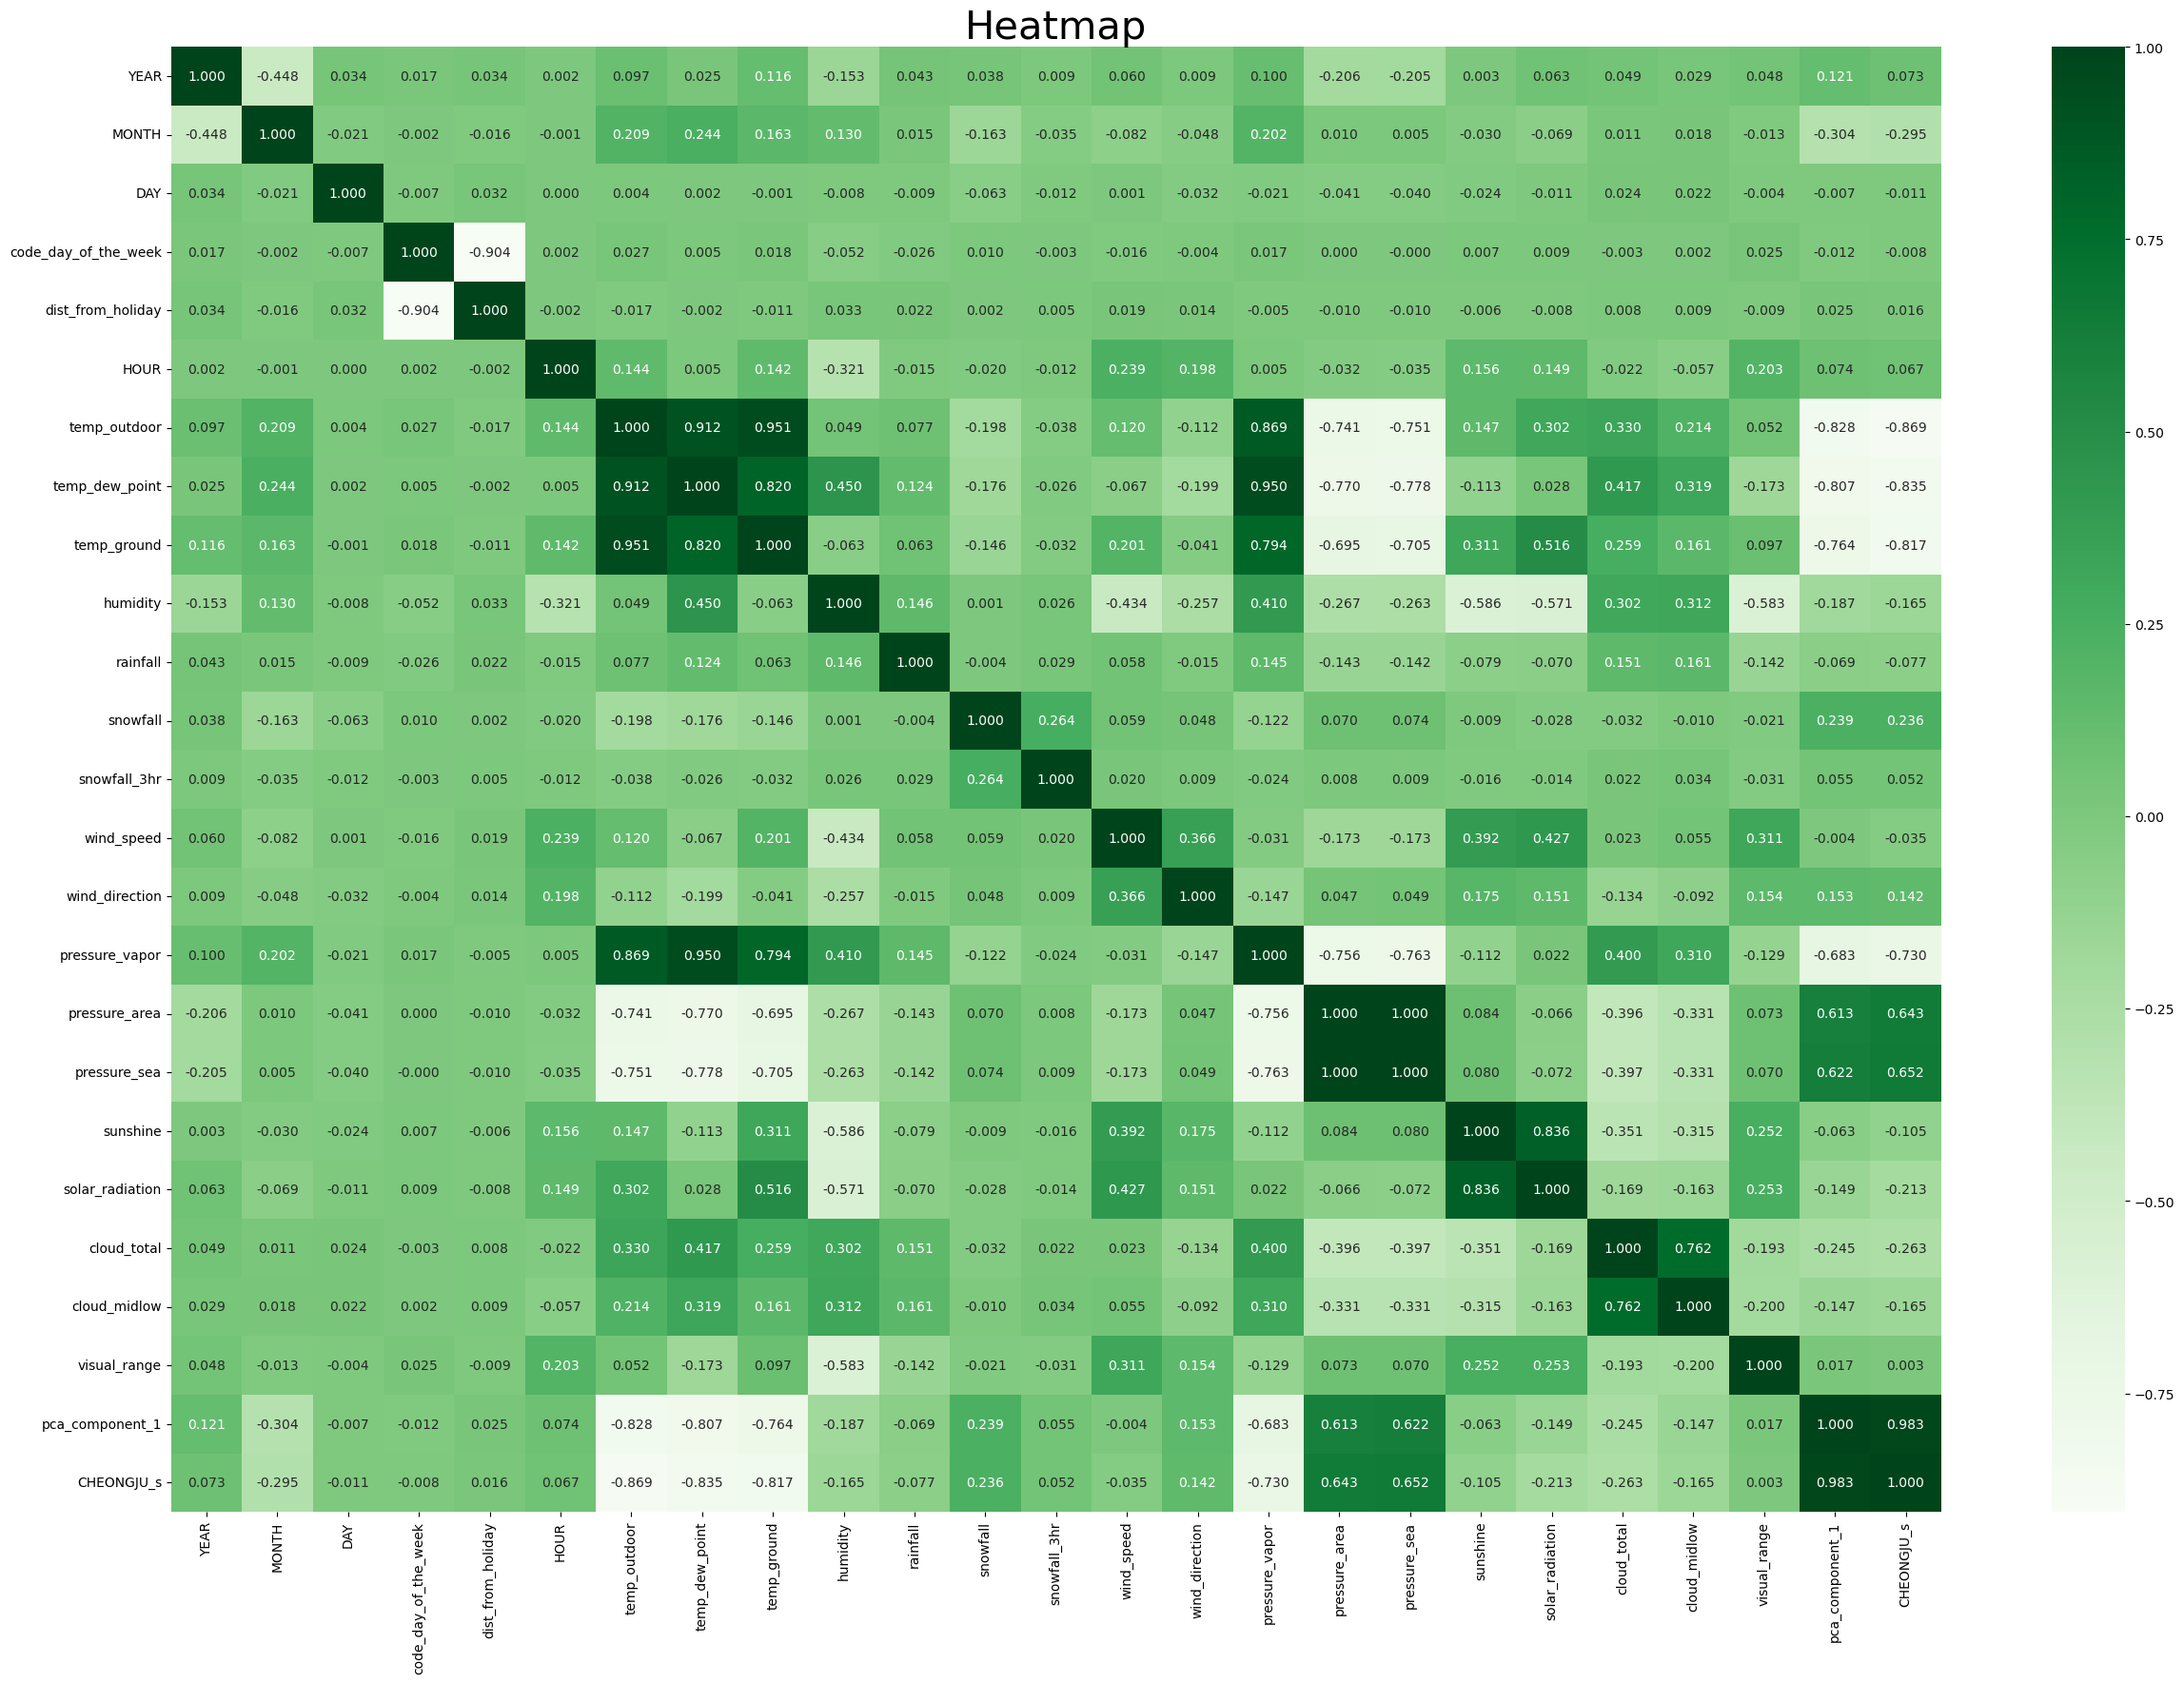

In [45]:
## Heatmap 분석
plt.figure(figsize=(30,20))
ax = sns.heatmap(df_corr, annot=True, fmt='.3f', cmap='Greens')
plt.title("Heatmap", fontsize=30)
plt.show()

In [46]:
# df_kdhc_heat_WD = df_kdhc_heat_WD.drop(["METER_DATE"], axis = 1)
# df_kdhc_heat_WE = df_kdhc_heat_WE.drop(["METER_DATE"], axis = 1)

# df_tar = df_kdhc_heat_WD
df_tar = df_kdhc_heat_WE

X = df_tar.drop([col_tar], axis=1)
Y = df_tar[[col_tar]]

In [47]:
trainSet, testSet = train_test_split(df_tar, test_size=0.3, shuffle=False)
print(trainSet.shape, testSet.shape)

(6586, 24) (2823, 24)


In [48]:
trainXX = trainSet.drop([col_tar],axis=1)
trainYY = trainSet[[col_tar]]

testXX = testSet.drop([col_tar],axis=1)
testYY = testSet[[col_tar]]

In [49]:
trainXXindex = trainXX.index
trainXXcolumns = trainXX.columns

trainYYindex = trainYY.index
trainYYcolumns = trainYY.columns

testXXindex = testXX.index
testXXcolumns = testXX.columns

testYYindex = testYY.index
testYYcolumns = testYY.columns

In [50]:
d_trainXX=pd.DataFrame(trainXX, index=trainXXindex, columns=trainXXcolumns)
# d_trainXX=pd.DataFrame(trainXX, index=trainXXindex, columns=trainXXcolumns)
d_trainYY=trainYY

#d_valX=pd.DataFrame(func_valSet, index=valXindex, columns=valXcolumns)
#d_valY=valY

d_testXX=pd.DataFrame(testXX, index=testXXindex, columns=testXXcolumns)
# d_testXX=pd.DataFrame(trainXX, index=testXXindex, columns=testXXcolumns)
d_testYY=testYY

In [51]:
params = {
    'learning_rate': 0.01,
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

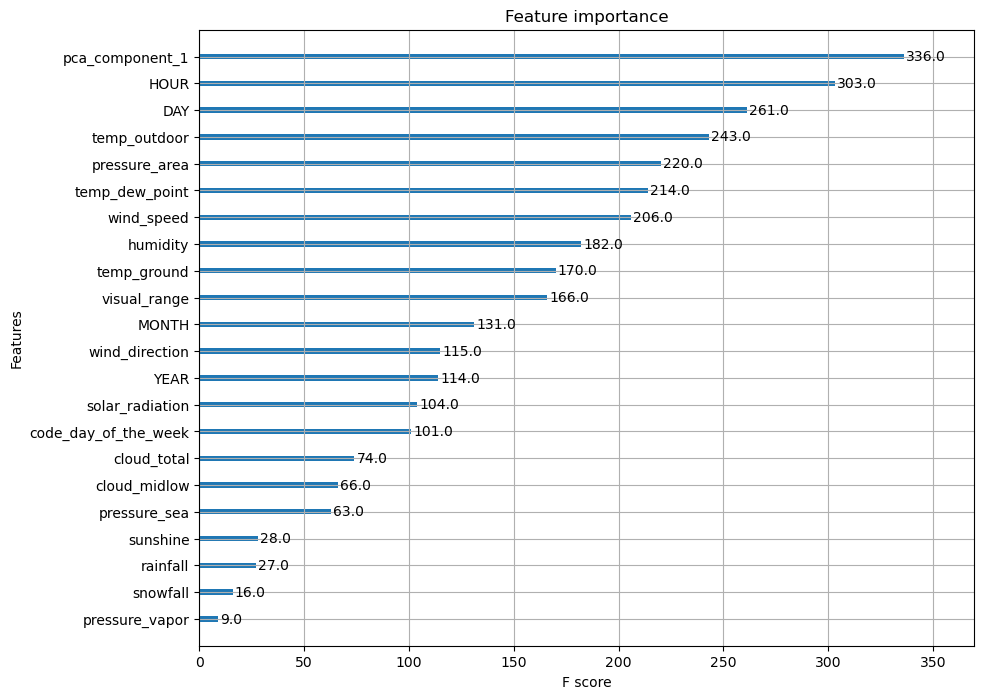

In [52]:
XGB_CJ = xgb.XGBRegressor(n_estimators = 1000)
XGB_CJ.fit(d_trainXX, d_trainYY
           , eval_set=[(d_testXX, d_testYY)]
           , early_stopping_rounds = 50, verbose = False)

## 주요 변수 판단
plot_importance(XGB_CJ)

In [53]:
XGB_pred = XGB_CJ.predict(d_testXX)
XGB_pred = np.reshape(XGB_pred,(-1,1))

In [54]:
d_actual = testYY.to_numpy()
d_actual = np.reshape(d_actual,(-1,1))

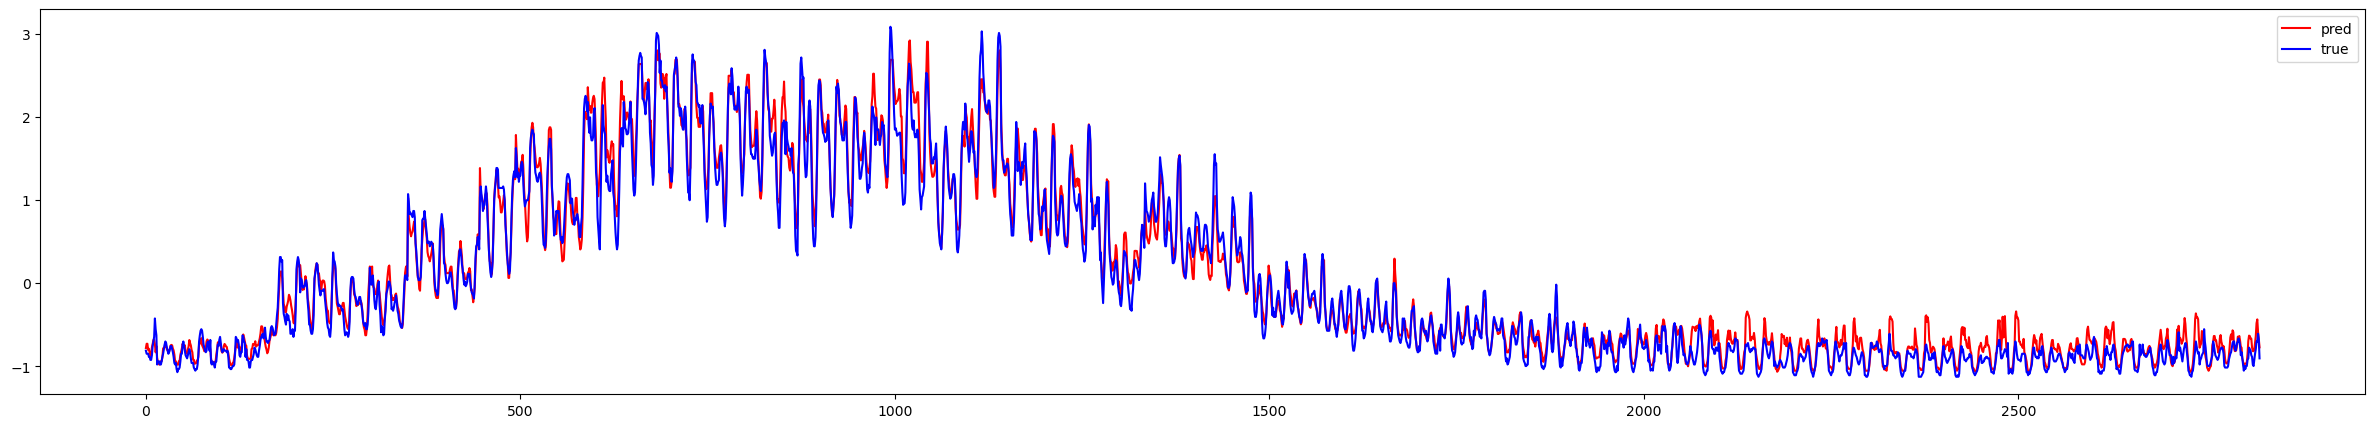

In [55]:
plt.figure(figsize=(30,5))
plt.plot(XGB_pred,color='red',label='pred')
plt.plot(d_actual,color='blue',label='true')
plt.legend()
plt.show()

In [56]:
from sklearn.metrics import mean_absolute_percentage_error
print('mean_absolute_percentage_error : ', mean_absolute_percentage_error(d_actual, XGB_pred))

from sklearn.metrics import mean_absolute_error
print('mean_absolute_error : ', mean_absolute_error(d_actual, XGB_pred))                                      

from sklearn.metrics import mean_squared_error
print('mean_squared_error : ', mean_squared_error(d_actual, XGB_pred))

from sklearn.metrics import r2_score   # model.score
print('r2_score : ', r2_score(d_actual, XGB_pred))

mean_absolute_percentage_error :  0.6816284271931431
mean_absolute_error :  0.12092403750464198
mean_squared_error :  0.026262401867339077
r2_score :  0.977206929741467


In [57]:
print(trainXX.shape, trainYY.shape)
print(testXX.shape, testYY.shape)

(6586, 23) (6586, 1)
(2823, 23) (2823, 1)
